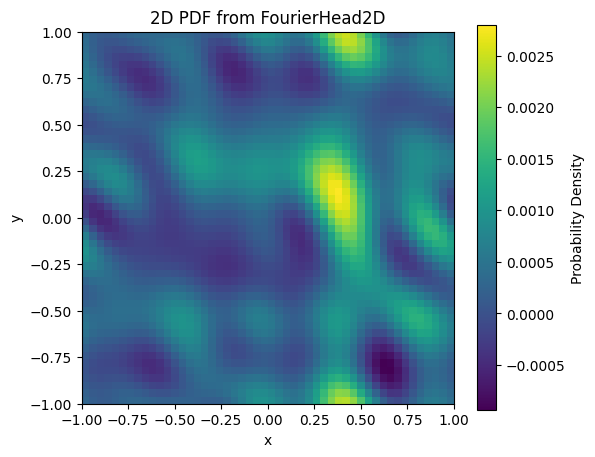

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

class FourierHead2D(nn.Module):
    def __init__(self, dim_input, dim_output_x, dim_output_y, num_freq_x, num_freq_y,
                 regularization_gamma=0.0, const_inverse_softmax=1e-5,
                 init_denominator_weight=100.0, init_denominator_bias=100.0,
                 dtype=torch.float32, device="cpu"):
        """
        2D Fourier Head: learns a Fourier‐series–based PDF over [-1,1]×[-1,1].

        Arguments:
        - dim_input: dimension of input feature vector
        - dim_output_x: number of bins along x (PDF resolution in x)
        - dim_output_y: number of bins along y (PDF resolution in y)
        - num_freq_x: maximum Fourier frequency in x direction
        - num_freq_y: maximum Fourier frequency in y direction
        - regularization_gamma, const_inverse_softmax, init_denominator_... : 
          same roles as in the 1D version, just carried over
        """
        super().__init__()
        self.dim_input = dim_input
        self.dim_output_x = dim_output_x
        self.dim_output_y = dim_output_y
        self.num_freq_x = num_freq_x
        self.num_freq_y = num_freq_y
        self.regularization_gamma = regularization_gamma
        self.const_inverse_softmax = const_inverse_softmax
        self.init_denominator_weight = init_denominator_weight
        self.init_denominator_bias = init_denominator_bias
        self.dtype = dtype
        self.device = device

        # Linear layer to predict (real + imaginary) for all (num_freq_x+1)*(num_freq_y+1) coefficients
        self.fc = nn.Linear(dim_input, 2 * (num_freq_x + 1) * (num_freq_y + 1))
        # Scale down weights and bias initially
        with torch.no_grad():
            self.fc.weight.div_(self.init_denominator_weight)
            self.fc.bias.div_(self.init_denominator_bias)

        # Precompute bin centers ([-1..1] divided into dim_output_x × dim_output_y bins)
        x_edges = torch.linspace(-1, 1, dim_output_x + 1, device=device)
        y_edges = torch.linspace(-1, 1, dim_output_y + 1, device=device)
        self.x_centers = ((x_edges[:-1] + x_edges[1:]) / 2).to(device)  # shape: (dim_output_x,)
        self.y_centers = ((y_edges[:-1] + y_edges[1:]) / 2).to(device)  # shape: (dim_output_y,)

    def autocorrelate2d(self, seq):
        """
        Compute the 2D autocorrelation via grouped conv2d:
          seq: (batch, M, N), complex-valued
        Returns:
          (batch, M, N) autocorrelation for nonnegative lags (p ≥ 0, q ≥ 0).
        """
        batch, M, N = seq.shape
        # Move batch dimension into "channels" for conv2d
        input_tensor = seq.unsqueeze(0)         # shape: (1, batch, M, N)
        weight = seq.unsqueeze(1).conj()        # shape: (batch, 1, M, N)
        # Full 2D convolution with padding to capture all lags from −(M−1) to +(M−1), etc.
        conv_full = F.conv2d(input_tensor, weight,
                             padding=(M - 1, N - 1),
                             groups=batch)
        # conv_full shape: (1, batch, 2M−1, 2N−1)
        # Keep only nonnegative lags → indices [M−1 : , N−1 : ]
        autocorr = conv_full[0, :, M - 1 :, N - 1 :]  # shape: (batch, M, N)
        return autocorr

    def compute_fourier_coefficients(self, x):
        """
        From input x (batch, dim_input), predict 2D complex sequence a[p,q] of size (num_freq_x+1)×(num_freq_y+1),
        then autocorrelate to get R[p,q].
        """
        batch = x.shape[0]
        params = self.fc(x)  # shape: (batch, 2*K) where K = (num_freq_x+1)*(num_freq_y+1)
        K = (self.num_freq_x + 1) * (self.num_freq_y + 1)

        # Split real and imaginary parts, then reshape to (batch, M, N)
        real = params[:, :K].reshape(batch, self.num_freq_x + 1, self.num_freq_y + 1).to(self.dtype)
        imag = params[:, K:].reshape(batch, self.num_freq_x + 1, self.num_freq_y + 1).to(self.dtype)
        a = torch.complex(real, imag)  # shape: (batch, M, N)

        # Autocorrelate to get R
        R = self.autocorrelate2d(a)    # shape: (batch, M, N)
        return R

    def evaluate_pdf(self, R):
        """
        Given autocorrelation R (batch, M, N), build a real-valued PDF on a 2D grid:
          - Normalizes by R[0,0]  (ensures integral = 1 over [-1,1]²)
          - Builds f(x,y) = 0.25  +  Re{ Σ_{i>0,j>0} R_{ij} e^{iπ(i x + j y)}  +  Σ_{i>0} R_{i0} e^{iπ i x}  +  Σ_{j>0} R_{0j} e^{iπ j y} }
        """
        batch, M, N = R.shape
        # Normalize so that R[0,0] = 1 (real)
        denom = R[:, 0, 0].real             # shape: (batch,)
        R_norm = R / denom[:, None, None]   # shape: (batch, M, N)

        # Build meshgrid of bin centers
        xx, yy = torch.meshgrid(self.x_centers, self.y_centers, indexing="xy")
        xx = xx.to(self.device)
        yy = yy.to(self.device)

        # Start with constant 0.25 → ∫_{-1..1, -1..1} 0.25 dx dy = 1
        f = torch.full((batch, self.dim_output_x, self.dim_output_y),
                       0.25, device=self.device, dtype=torch.float32)

        # Add terms for i>0, j>0
        for i in range(1, self.num_freq_x + 1):
            for j in range(1, self.num_freq_y + 1):
                coeff = R_norm[:, i, j]  # shape: (batch,)
                exp_term = torch.exp(1j * math.pi * (i * xx + j * yy))  # (dim_x, dim_y)
                f += (coeff[:, None, None] * exp_term).real

        # Add i>0, j=0 terms
        for i in range(1, self.num_freq_x + 1):
            coeff = R_norm[:, i, 0]
            exp_term = torch.exp(1j * math.pi * (i * xx))  # no y component
            f += (coeff[:, None, None] * exp_term).real

        # Add i=0, j>0 terms
        for j in range(1, self.num_freq_y + 1):
            coeff = R_norm[:, 0, j]
            exp_term = torch.exp(1j * math.pi * (j * yy))  # no x component
            f += (coeff[:, None, None] * exp_term).real

        return f

    def forward(self, x):
        """
        Forward pass: x shape (batch, dim_input) → returns PDF grid (batch, dim_x, dim_y)
        """
        R = self.compute_fourier_coefficients(x)    # (batch, M, N)
        f = self.evaluate_pdf(R)                   # (batch, dim_out_x, dim_out_y)
        # Discrete normalization so sum over grid ≈ 1
        total = f.sum(dim=(1, 2), keepdim=True)    # (batch, 1, 1)
        pdf = f / total
        return pdf

# ----------------------------------------
# Example test and visualization in 2D:
# ----------------------------------------
device = "cpu"  # or "cuda" if you have a GPU set up

# Hyperparameters
dim_input = 10
dim_out_x = 50
dim_out_y = 50
num_freq_x = 5
num_freq_y = 5

# Instantiate the 2D Fourier Head
model = FourierHead2D(dim_input, dim_out_x, dim_out_y, num_freq_x, num_freq_y, device=device)
model.to(device)

# Create a random input vector
x = torch.randn(1, dim_input, dtype=torch.float32, device=device)

# Compute the 2D PDF grid
with torch.no_grad():
    pdf = model(x)  # shape: (1, 50, 50)

# Convert to NumPy for plotting
pdf_np = pdf[0].cpu().numpy()

# Plot using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(pdf_np, extent=[-1, 1, -1, 1], origin="lower")
plt.colorbar(label="Probability Density")
plt.title("2D PDF from FourierHead2D")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [3]:
!pip install imageio

In [52]:
# Fourier-head toy training with live GIF
# --------------------------------------
import torch, math, matplotlib.pyplot as plt, imageio, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import trange

# ─── 2-D Fourier head ────────────────────────────────────────────────
class FourierHead2D(nn.Module):
    def __init__(self, dim_in, nx, ny, fx, fy, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.fx, self.fy = nx, ny, fx, fy
        self.fc = nn.Linear(dim_in, 2 * (fx + 1) * (fy + 1))
        with torch.no_grad():
            self.fc.weight.div_(100); self.fc.bias.div_(100)
        # Bin centres in [-1,1]×[-1,1]
        self.xc = torch.linspace(-1.0, 1.0, nx + 1)[:-1] + 1 / nx
        self.yc = torch.linspace(-1.0, 1.0, ny + 1)[:-1] + 1 / ny
        self.register_buffer("xc_", self.xc); self.register_buffer("yc_", self.yc)

    def _acorr2d(self, a):                 # autocorr via grouped conv2d
        B, M, N = a.shape
        full = F.conv2d(a.unsqueeze(0), a.unsqueeze(1).conj(),
                        padding=(M - 1, N - 1), groups=B)
        return full[0, :, M - 1:, N - 1:]  # keep p,q ≥ 0

    def _R(self, x):
        B = x.size(0); M, N = self.fx + 1, self.fy + 1
        p = self.fc(x); K = M * N
        a = torch.complex(p[:, :K].view(B, M, N), p[:, K:].view(B, M, N))
        return self._acorr2d(a)

    def _pdf(self, R):
        B = R.size(0); f = torch.full((B, self.nx, self.ny), 0.25, device=R.device)
        R = R / R[:, :1, :1].real  # normalise so R00 = 1
        xx, yy = torch.meshgrid(self.xc_, self.yc_, indexing="xy")
        xx, yy = xx.to(R.device), yy.to(R.device)

        for i in range(1, self.fx + 1):
            f += (R[:, i, 0].real)[:, None, None] * torch.cos(math.pi * i * xx)
        for j in range(1, self.fy + 1):
            f += (R[:, 0, j].real)[:, None, None] * torch.cos(math.pi * j * yy)
        for i in range(1, self.fx + 1):
            for j in range(1, self.fy + 1):
                f += (R[:, i, j].real)[:, None, None] * torch.cos(math.pi * (i * xx + j * yy))
        return f / f.sum(dim=(1, 2), keepdim=True)

    def forward(self, x):  # returns PDF grid (B,nx,ny)
        return self._pdf(self._R(x))


# ─── Toy data ────────────────────────────────────────────────────────
device = "cuda"                       # change to "cuda" if you have a GPU
model = FourierHead2D(10, 50, 50, 50, 50).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-4)

# two deterministic inputs → two different target coordinates
x_left  = torch.tensor([[ 1.0] + [0.0]*9], device=device)
x_right = torch.tensor([[-1.0] + [0.0]*9], device=device)
X       = torch.cat([x_left, x_right])           # shape (2,10)

# map target coords to discrete grid index
def coord2idx(xval, yval, xc, yc):
    ix = torch.argmin(torch.abs(xc - xval)).item()
    iy = torch.argmin(torch.abs(yc - yval)).item()
    return ix * yc.numel() + iy

idx_target = torch.tensor([
    coord2idx(-0.5, 0.5, model.xc_, model.yc_),
    coord2idx( 0.5, 0.5, model.xc_, model.yc_)
], device=device)

# ─── Train & capture frames ──────────────────────────────────────────
frames, EPOCHS, every = [], 10, 1           # GIF every 1 epochs
for epoch in trange(EPOCHS):
    opt.zero_grad()
    pdf = model(X)                    # (2,50,50)
    loss = -torch.log(pdf.view(2, -1)[range(2), idx_target]).mean()
    loss.backward(); opt.step()

    if epoch % every == 0 or epoch == EPOCHS-1:
        with torch.no_grad():
            img = model(X)[0].cpu().numpy()
        fig = plt.figure(figsize=(4,3))
        plt.imshow(img, extent=[-1,1,-1,1], origin="lower")
        plt.title(f"Epoch {epoch}")
        plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
        frames.append(frame.reshape(*fig.canvas.get_width_height()[::-1], 3))
        plt.close(fig)

# Save GIF
gif_path = "/home/ec2-user/repos/fourier-head/notebooks/fourier2d_training.gif"
imageio.mimsave(gif_path, frames, fps=5)
print("Saved:", gif_path)


  0%|                                                                                                          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_8139/2235126978.py:89: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]

Saved: /home/ec2-user/repos/fourier-head/notebooks/fourier2d_training.gif


In [16]:
# -----------------------------------------------------------
# FourierHead-2D toy task — train & create a 3-D GIF snapshot
# -----------------------------------------------------------
#
# • Two fixed input vectors map to two target points:
#     (-0.5, 0.5)  and  (0.5, 0.5)
# • Model: 2-D Fourier head (learns PDF on [-1,1]×[-1,1])
# • Each 5 epochs we capture a 3-D surface plot of the PDF
# • At the end we save an animated GIF in the notebook folder
#
# Just drop this whole cell into JupyterLab and run.
# -----------------------------------------------------------

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # registers 3-D projection
try:
    from tqdm.auto import trange                # pretty progress if ipywidgets present
except ImportError:
    def trange(n, **kw): return range(n)        # bare-bones fallback

# ────────────────────────────────────────────────────────────
#  1. 2-D Fourier Head
# ────────────────────────────────────────────────────────────
class FourierHead2D(nn.Module):
    def __init__(self, dim_in, nx, ny, fx, fy, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.fx, self.fy = nx, ny, fx, fy
        self.fc = nn.Linear(dim_in, 2 * (fx + 1) * (fy + 1))
        with torch.no_grad():
            self.fc.weight.div_(100.0)
            self.fc.bias.div_(100.0)

        # Bin centres (one per discrete cell)
        self.register_buffer("xc", torch.linspace(-1.0, 1.0, nx + 1)[:-1] + 1 / nx)
        self.register_buffer("yc", torch.linspace(-1.0, 1.0, ny + 1)[:-1] + 1 / ny)

    # full 2-D autocorrelation via grouped conv2d
    def _acorr(self, a):
        B, M, N = a.shape
        full = F.conv2d(a.unsqueeze(0), a.unsqueeze(1).conj(),
                        padding=(M - 1, N - 1), groups=B)
        return full[0, :, M - 1 :, N - 1 :]     # keep non-negative lags

    def _R(self, x):
        B = x.size(0); M, N = self.fx + 1, self.fy + 1
        p = self.fc(x); K = M * N
        a = torch.complex(p[:, :K].view(B, M, N),
                          p[:, K:].view(B, M, N))
        return self._acorr(a)                   # (B,M,N)

    def _pdf(self, R):
        B = R.size(0)
        R = R / R[:, :1, :1].real              # normalise so R₀₀ = 1
        f = torch.full((B, self.nx, self.ny), 0.25, device=R.device)

        xx, yy = torch.meshgrid(self.xc, self.yc, indexing="xy")
        xx, yy = xx.to(R.device), yy.to(R.device)

        # add cosine terms (Hermitian symmetry → real)
        for i in range(1, self.fx + 1):
            f += (R[:, i, 0].real)[:, None, None] * torch.cos(math.pi * i * xx)
        for j in range(1, self.fy + 1):
            f += (R[:, 0, j].real)[:, None, None] * torch.cos(math.pi * j * yy)
        for i in range(1, self.fx + 1):
            for j in range(1, self.fy + 1):
                f += (R[:, i, j].real)[:, None, None] * torch.cos(math.pi * (i * xx + j * yy))

        return f / f.sum(dim=(1, 2), keepdim=True)

    def forward(self, x):
        return self._pdf(self._R(x))            # (B,nx,ny)

# ────────────────────────────────────────────────────────────
#  2. Hyper-params & data
# ────────────────────────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
dim_in   = 10
nx = ny  = 50
fx = fy  = 5
lr       = 1e-4          # lower learning rate
epochs   = 100
snap_int = 1             # capture every N epochs

model = FourierHead2D(dim_in, nx, ny, fx, fy, device=device).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

# two deterministic inputs
x_left  = torch.tensor([[ 1.0] + [0.0]*9], device=device)
x_right = torch.tensor([[-1.0] + [0.0]*9], device=device)
X       = torch.cat([x_left, x_right])         # (2,10)

# map target coords to grid index
def coord_to_index(xv, yv, xc, yc):
    ix = torch.argmin(torch.abs(xc - xv)).item()
    iy = torch.argmin(torch.abs(yc - yv)).item()
    return ix * yc.numel() + iy

idx_target = torch.tensor([
    coord_to_index(-0.5, 0.5, model.xc, model.yc),
    coord_to_index( 0.5, 0.5, model.xc, model.yc)
], device=device)

# ────────────────────────────────────────────────────────────
#  3. Training loop + frame capture
# ────────────────────────────────────────────────────────────
frames = []
for epoch in trange(epochs, desc="Training"):
    opt.zero_grad()
    pdf = model(X)
    loss = -torch.log(pdf.view(2, -1)[range(2), idx_target]).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs - 1:
        with torch.no_grad():
            img = model(X)[0].cpu().numpy()     # (nx,ny)

        # 3-D surface plot
        Xg, Yg = np.meshgrid(model.xc.cpu(), model.yc.cpu(), indexing="xy")
        fig = plt.figure(figsize=(5, 4), dpi=180)
        ax = fig.add_subplot(111, projection="3d")
        surf = ax.plot_surface(Xg, Yg, img,
                               cmap="viridis", edgecolor="none",
                               antialiased=True)
        ax.set_zlim(0, img.max() * 1.1)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("PDF")
        ax.set_title(f"Epoch {epoch}")
        fig.tight_layout()

        # store frame
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])   # RGBA → RGB
        frames.append(frame)
        plt.close(fig)

# ────────────────────────────────────────────────────────────
#  4. Save GIF
# ────────────────────────────────────────────────────────────
gif_name = "fourier2d_training_3d.gif"
imageio.mimsave(gif_name, frames, fps=5)
print(f"✅  Saved GIF → {os.path.abspath(gif_name)}")


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_training_3d.gif


In [26]:
# -----------------------------------------------------------
# FourierHead-2D toy task — train & create a fixed-z GIF
# -----------------------------------------------------------

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # registers 3-D projection
try: from tqdm.auto import trange
except ImportError: trange = lambda n, **k: range(n)

# ------------- 1. 2-D Fourier head -------------------------
class FourierHead2D(nn.Module):
    def __init__(self, dim_in, nx, ny, fx, fy, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.fx, self.fy = nx, ny, fx, fy
        self.fc = nn.Linear(dim_in, 2 * (fx + 1) * (fy + 1))
        with torch.no_grad():
            self.fc.weight.div_(100.0); self.fc.bias.div_(100.0)
        self.register_buffer("xc", torch.linspace(-1, 1, nx + 1)[:-1] + 1 / nx)
        self.register_buffer("yc", torch.linspace(-1, 1, ny + 1)[:-1] + 1 / ny)

    def _acorr(self, a):
        B, M, N = a.shape
        return F.conv2d(a[None], a[:,None].conj(),
                        padding=(M-1, N-1), groups=B)[0, :, M-1:, N-1:]

    def _R(self, x):
        B = x.size(0); M, N = self.fx + 1, self.fy + 1
        p = self.fc(x); K = M * N
        a = torch.complex(p[:, :K].view(B, M, N),
                          p[:, K:].view(B, M, N))
        return self._acorr(a)

    def _pdf(self, R):
        B = R.size(0); R = R / R[:, :1, :1].real
        f = torch.full((B, self.nx, self.ny), 0.25, device=R.device)
        xx, yy = torch.meshgrid(self.xc, self.yc, indexing="xy")
        xx, yy = xx.to(R.device), yy.to(R.device)

        for i in range(1, self.fx + 1):
            f += (R[:, i, 0].real)[:, None, None] * torch.cos(math.pi * i * xx)
        for j in range(1, self.fy + 1):
            f += (R[:, 0, j].real)[:, None, None] * torch.cos(math.pi * j * yy)
        for i in range(1, self.fx + 1):
            for j in range(1, self.fy + 1):
                f += (R[:, i, j].real)[:, None, None] * torch.cos(math.pi * (i * xx + j * yy))
        return f / f.sum(dim=(1, 2), keepdim=True)

    def forward(self, x): return self._pdf(self._R(x))

# ------------- 2. Hyper-params & toy data ------------------
device   = "cuda" if torch.cuda.is_available() else "cpu"
dim_in   = 10; nx = ny = 100; fx = fy = 20
lr = 1e-3; epochs = 20; snap_int = 1
Z_MAX = 0.03                                  # ← fixed z-axis upper bound

model = FourierHead2D(dim_in, nx, ny, fx, fy, device=device).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

x_left  = torch.tensor([[ 1.0]+[0]*9], device=device)
x_right = torch.tensor([[-1.0]+[0]*9], device=device)
X = torch.cat([x_left, x_right])

def idx_of(xv, yv, xc, yc):
    ix = torch.argmin(torch.abs(xc - xv)).item()
    iy = torch.argmin(torch.abs(yc - yv)).item()
    return ix * yc.numel() + iy

idx_target = torch.tensor([
    idx_of(-0.5, 0.5, model.xc, model.yc),
    idx_of( 0.5, 0.5, model.xc, model.yc)
], device=device)

# ------------- 3. Train & capture 3-D frames ---------------
frames = []
for epoch in trange(epochs, desc="Training"):
    opt.zero_grad()
    pdf = model(X)
    loss = -torch.log(pdf.view(2, -1)[range(2), idx_target]).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs-1:
        with torch.no_grad():
            img = model(X)[0].cpu().numpy()
        Xg, Yg = np.meshgrid(model.xc.cpu(), model.yc.cpu(), indexing="xy")
        fig = plt.figure(figsize=(5,4), dpi=180)
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Xg, Yg, img, cmap="viridis", edgecolor="none", antialiased=True)
        ax.set_zlim(0, Z_MAX)                # ← never resizes
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("PDF")
        ax.set_title(f"Epoch {epoch}")
        fig.tight_layout()

        fig.canvas.draw()
        w,h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])   # RGBA→RGB
        frames.append(frame)
        plt.close(fig)

# ------------- 4. Save GIF ---------------------------------
gif_name = "fourier2d_fixedZ.gif"
imageio.mimsave(gif_name, frames, fps=5)
print(f"✅  Saved GIF → {os.path.abspath(gif_name)}")


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.43it/s]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_fixedZ.gif


In [29]:
# ------------------------------------------------------------------
# 2-D Fourier-Head “disk” basis  ➜  GIF of fixed-z 3-D learning curve
# ------------------------------------------------------------------
#  * Keeps only Fourier modes whose indices satisfy i² + j² ≤ R²
#  * Uses conv2d autocorrelation on a (R+1)×(R+1) grid but zeros out
#    coefficients outside that disk, so the PDF remains ≥0 everywhere.
#  * Captures a high-DPI 3-D surface plot every 5 epochs (z-axis fixed)
#  * Saves the animation as fourier2d_disk.gif next to the notebook
#
# Copy–paste this single cell into Jupyter Lab and run.               

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # registers 3-D projection
try: from tqdm.auto import trange
except ImportError: trange = lambda n, **k: range(n)

# ───────────────────────────────────────────────────────────
#  1. 2-D Fourier head with DISK mask
# ───────────────────────────────────────────────────────────
class DiskFourierHead2D(nn.Module):
    """
    Fourier PDF on [-1,1]² using only modes (i,j) with i²+j² ≤ R².
    The trick: build a dense (R+1)×(R+1) tensor, zero out indices
    outside the disk, then conv2d autocorrelation guarantees
    positive-definite coefficients.
    """
    def __init__(self, dim_in, nx, ny, R, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.R = nx, ny, R
        self.device = device

        # Dense grid size (R+1)×(R+1)  (non-neg i,j only).
        self.fc = nn.Linear(dim_in, 2 * (R + 1) * (R + 1))
        with torch.no_grad():
            self.fc.weight.div_(100.0); self.fc.bias.div_(100.0)

        # Boolean mask selecting the disk
        mask = torch.zeros(R + 1, R + 1, dtype=torch.bool)
        for i in range(R + 1):
            for j in range(R + 1):
                if i * i + j * j <= R * R:
                    mask[i, j] = True
        self.register_buffer("mask", mask)

        # Pre-compute centres of discrete bins
        self.register_buffer("xc", torch.linspace(-1, 1, nx + 1)[:-1] + 1 / nx)
        self.register_buffer("yc", torch.linspace(-1, 1, ny + 1)[:-1] + 1 / ny)

    # Full 2-D autocorrelation (batch-grouped conv2d)
    def _acorr(self, a):                       # a: (B,M,N) complex
        B, M, N = a.shape
        return F.conv2d(a[None], a[:, None].conj(),
                        padding=(M - 1, N - 1), groups=B)[0, :, M - 1 :, N - 1 :]

    def _R(self, x):                            # positive-definite coeffs
        B = x.size(0); M = N = self.R + 1
        p = self.fc(x)
        real = p[:, :M * N].view(B, M, N); imag = p[:, M * N :].view(B, M, N)
        a = torch.complex(real, imag) * self.mask        # zero outside disk
        return self._acorr(a)                            # (B,M,N)

    def _pdf(self, R):                          # evaluate on grid
        B, M, N = R.shape
        R = R / R[:, :1, :1].real               # normalise so R00 = 1
        f = torch.full((B, self.nx, self.ny), 0.25, device=R.device)

        xx, yy = torch.meshgrid(self.xc, self.yc, indexing="xy")
        xx, yy = xx.to(R.device), yy.to(R.device)

        for i in range(M):
            for j in range(N):
                if i == 0 and j == 0:                  # constant done
                    continue
                if not self.mask[i, j]:
                    continue
                coef = R[:, i, j].real                 # (B,)
                f += (coef[:, None, None] *
                      torch.cos(math.pi * (i * xx + j * yy)))

        return f / f.sum(dim=(1, 2), keepdim=True)

    def forward(self, x): return self._pdf(self._R(x))


# ───────────────────────────────────────────────────────────
#  2. Hyper-parameters & toy data
# ───────────────────────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
dim_in   = 10
nx = ny  = 100          # finer 100×100 grid
R        = 6            # disk radius → frequencies with i²+j² ≤ 36
lr       = 1e-3
epochs   = 20
snap_int = 1
Z_MAX    = 0.03         # fixed z-axis upper bound

model = DiskFourierHead2D(dim_in, nx, ny, R, device).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

# two deterministic inputs
x_left  = torch.tensor([[ 1.0]+[0]*9], device=device)
x_right = torch.tensor([[-1.0]+[0]*9], device=device)
X = torch.cat([x_left, x_right])

def idx_of(xv, yv, xc, yc):
    ix = torch.argmin(torch.abs(xc - xv)).item()
    iy = torch.argmin(torch.abs(yc - yv)).item()
    return ix * yc.numel() + iy

idx_target = torch.tensor([
    idx_of(-0.5, 0.5, model.xc, model.yc),
    idx_of( 0.5, 0.5, model.xc, model.yc)
], device=device)

# ───────────────────────────────────────────────────────────
#  3. Train & capture 3-D frames
# ───────────────────────────────────────────────────────────
frames = []
for epoch in trange(epochs, desc="Training"):
    opt.zero_grad()
    pdf = model(X)
    loss = -torch.log(pdf.view(2, -1)[range(2), idx_target]).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs - 1:
        with torch.no_grad():
            img = model(X)[0].cpu().numpy()

        Xg, Yg = np.meshgrid(model.xc.cpu(), model.yc.cpu(), indexing="xy")
        fig = plt.figure(figsize=(5, 4), dpi=180)
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Xg, Yg, img, cmap="viridis",
                        edgecolor="none", antialiased=True)
        ax.set_zlim(0, Z_MAX)                  # fixed z-axis
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("PDF")
        ax.set_title(f"Epoch {epoch}")
        fig.tight_layout()

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])   # drop alpha
        frames.append(frame)
        plt.close(fig)

# ───────────────────────────────────────────────────────────
#  4. Save GIF
# ───────────────────────────────────────────────────────────
gif_name = "fourier2d_disk.gif"
imageio.mimsave(gif_name, frames, fps=5)
print(f"✅  Saved GIF → {os.path.abspath(gif_name)}")


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.04it/s]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_disk.gif


In [32]:
# ------------------------------------------------------------------
# 2-D Fourier head with a full rectangular frequency block
# ------------------------------------------------------------------
#  • Modes: i = −Fx…Fx,  j = −Fy…Fy   (rectangular grid)
#  • Autocorrelation guarantees positivity
#  • High-res 3-D GIF with fixed z-axis
# ------------------------------------------------------------------

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # 3-D projection
try: from tqdm.auto import trange
except ImportError: trange = lambda n, **k: range(n)

# ───────────────────────────────────────────────────────────
# 1. 2-D Fourier head (full block, Fx×Fy)
# ───────────────────────────────────────────────────────────
class BlockFourierHead2D(nn.Module):
    """
    Uses every integer pair (i,j) with −Fx‥Fx and −Fy‥Fy.
    For real PDFs we only *store* the non-negative i,j half and
    reconstruct the full set via cosine identities.
    """
    def __init__(self, dim_in, nx, ny, Fx, Fy, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.Fx, self.Fy = nx, ny, Fx, Fy
        self.device = device

        # Learn (Fx+1)×(Fy+1) complex 'a' coefficients
        self.fc = nn.Linear(dim_in, 2 * (Fx + 1) * (Fy + 1))
        with torch.no_grad():
            self.fc.weight.div_(100.0); self.fc.bias.div_(100.0)

        # bin centres on [-1,1] × [-1,1]
        self.register_buffer("xc", torch.linspace(-1, 1, nx + 1)[:-1] + 1 / nx)
        self.register_buffer("yc", torch.linspace(-1, 1, ny + 1)[:-1] + 1 / ny)

    # Autocorrelation on dense (Fx+1)×(Fy+1) grid
    def _acorr(self, a):                        # a: (B,M,N) complex
        B, M, N = a.shape
        return F.conv2d(a[None], a[:, None].conj(),
                        padding=(M - 1, N - 1), groups=B)[0, :, M - 1 :, N - 1 :]

    def _R(self, x):
        B = x.size(0); M, N = self.Fx + 1, self.Fy + 1
        p = self.fc(x)
        real = p[:, :M * N].view(B, M, N)
        imag = p[:, M * N :].view(B, M, N)
        a = torch.complex(real, imag)           # unconstrained
        return self._acorr(a)                   # (B,M,N) non-negative lags

    def _pdf(self, R):
        B, M, N = R.shape
        Rn = R / R[:, :1, :1].real             # R₀₀ = 1
        f = torch.full((B, self.nx, self.ny), 0.25, device=R.device)

        xx, yy = torch.meshgrid(self.xc, self.yc, indexing="xy")
        xx, yy = xx.to(R.device), yy.to(R.device)

        # add cos(pi*(i x)) & cos(pi*(j y)) and full 2-D cos(pi*(i x + j y))
        for i in range(1, M):
            f += (Rn[:, i, 0].real)[:, None, None] * torch.cos(math.pi * i * xx)
        for j in range(1, N):
            f += (Rn[:, 0, j].real)[:, None, None] * torch.cos(math.pi * j * yy)
        for i in range(1, M):
            for j in range(1, N):
                f += (Rn[:, i, j].real)[:, None, None] * torch.cos(math.pi * (i * xx + j * yy))

        return f / f.sum(dim=(1, 2), keepdim=True)

    def forward(self, x):
        return self._pdf(self._R(x))            # (B,nx,ny)

# ───────────────────────────────────────────────────────────
# 2. Hyper-parameters & toy data
# ───────────────────────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
dim_in   = 10
nx = ny  = 100            # grid resolution
Fx = Fy = 10               # frequency block size (−5…5)
lr       = 1e-3
epochs   = 20
snap_int = 1
Z_MAX    = 0.03            # fixed z upper bound

model = BlockFourierHead2D(dim_in, nx, ny, Fx, Fy, device).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

# fixed inputs → two targets
x_left  = torch.tensor([[ 1.0]+[0]*9], device=device)
x_right = torch.tensor([[-1.0]+[0]*9], device=device)
X = torch.cat([x_left, x_right])

def idx_of(xv, yv, xc, yc):
    ix = torch.argmin(torch.abs(xc - xv)).item()
    iy = torch.argmin(torch.abs(yc - yv)).item()
    return ix * yc.numel() + iy

idx_target = torch.tensor([
    idx_of(-0.5, 0.5, model.xc, model.yc),
    idx_of( 0.5, 0.5, model.xc, model.yc)
], device=device)

# ───────────────────────────────────────────────────────────
# 3. Train & capture 3-D frames
# ───────────────────────────────────────────────────────────
frames = []
for epoch in trange(epochs, desc="Training"):
    opt.zero_grad()
    pdf = model(X)
    loss = -torch.log(pdf.view(2, -1)[range(2), idx_target]).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs - 1:
        with torch.no_grad():
            img = model(X)[0].cpu().numpy()

        Xg, Yg = np.meshgrid(model.xc.cpu(), model.yc.cpu(), indexing="xy")
        fig = plt.figure(figsize=(5, 4), dpi=180)
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Xg, Yg, img,
                        cmap="viridis", edgecolor="none", antialiased=True)
        ax.set_zlim(0, Z_MAX)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("PDF")
        ax.set_title(f"Epoch {epoch}")
        fig.tight_layout()

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])
        frames.append(frame); plt.close(fig)

# ───────────────────────────────────────────────────────────
# 4. Save GIF
# ───────────────────────────────────────────────────────────
gif_name = "fourier2d_block.gif"
imageio.mimsave(gif_name, frames, fps=5)
print(f"✅  Saved GIF → {os.path.abspath(gif_name)}")


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_block.gif


In [33]:
# ------------------------------------------------------------------
# Full rectangular frequency block, PDF normalised analytically
# ------------------------------------------------------------------

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
try: from tqdm.auto import trange
except ImportError: trange = lambda n, **k: range(n)

class BlockFourierHead2D(nn.Module):
    def __init__(self, dim_in, nx, ny, Fx, Fy, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.Fx, self.Fy = nx, ny, Fx, Fy
        self.register_buffer("xc", torch.linspace(-1, 1, nx + 1)[:-1] + 1/nx)
        self.register_buffer("yc", torch.linspace(-1, 1, ny + 1)[:-1] + 1/ny)

        self.fc = nn.Linear(dim_in, 2*(Fx+1)*(Fy+1))
        with torch.no_grad():
            self.fc.weight.div_(100.0); self.fc.bias.div_(100.0)

    # grouped-conv2d autocorrelation → positive-definite coeffs
    def _acorr(self, a):
        B, M, N = a.shape
        return F.conv2d(a[None], a[:,None].conj(),
                        padding=(M-1, N-1), groups=B)[0, :, M-1:, N-1:]

    def _R(self, x):
        B, M, N = x.size(0), self.Fx+1, self.Fy+1
        y = self.fc(x)
        a = torch.complex(y[:,:M*N].view(B,M,N), y[:,M*N:].view(B,M,N))
        return self._acorr(a)                       # (B,M,N)

    def _pdf(self, R):
        B, M, N = R.shape
        R = R / R[:, :1, :1].real                  # ensure R00 = 1

        f = torch.full((B, self.nx, self.ny), 0.25, device=R.device)  # constant term
        xx, yy = torch.meshgrid(self.xc, self.yc, indexing="xy")
        xx, yy = xx.to(R.device), yy.to(R.device)

        for i in range(1, M):
            f += (R[:, i, 0].real)[:,None,None] * torch.cos(math.pi * i * xx)
        for j in range(1, N):
            f += (R[:, 0, j].real)[:,None,None] * torch.cos(math.pi * j * yy)
        for i in range(1, M):
            for j in range(1, N):
                f += (R[:, i, j].real)[:,None,None] * torch.cos(math.pi * (i*xx + j*yy))

        # f now integrates to 1 exactly; no discrete renormalisation
        return f

    def forward(self, x):
        return self._pdf(self._R(x))               # (B, nx, ny)

# ─── training+GIF code (unchanged except no f.sum normalisation) ───
device = "cuda" if torch.cuda.is_available() else "cpu"
nx = ny = 100; Fx = Fy = 5; dim_in = 10
model   = BlockFourierHead2D(dim_in, nx, ny, Fx, Fy, device).to(device)
opt     = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs  = 120; snap_int = 5; Z_MAX = 1.0

x_left  = torch.tensor([[ 1.0]+[0]*9], device=device)
x_right = torch.tensor([[-1.0]+[0]*9], device=device)
X       = torch.cat([x_left, x_right])

def idx(xv, yv):           # map a target coord → grid index
    ix = torch.argmin(torch.abs(model.xc - xv)).item()
    iy = torch.argmin(torch.abs(model.yc - yv)).item()
    return ix*model.yc.numel() + iy

targets = torch.tensor([idx(-0.5,0.5), idx(0.5,0.5)], device=device)

frames = []
for epoch in trange(epochs):
    opt.zero_grad()
    pdf = model(X)                                    # (2, nx, ny)
    loss = -torch.log(pdf.view(2,-1)[range(2), targets]).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs-1:
        img = model(X)[0].detach().cpu().numpy()
        Xg, Yg = np.meshgrid(model.xc.cpu(), model.yc.cpu(), indexing="xy")
        fig = plt.figure(figsize=(5,4), dpi=180)
        ax  = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Xg, Yg, img, cmap="viridis", edgecolor="none")
        ax.set_zlim(0, Z_MAX); ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.set_zlabel("PDF"); ax.set_title(f"Epoch {epoch}"); fig.tight_layout()
        fig.canvas.draw()
        w,h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])
        frames.append(frame); plt.close(fig)

gif_name = "fourier2d_block.gif"
imageio.mimsave(gif_name, frames, fps=5)
print("✅  Saved GIF →", os.path.abspath(gif_name))


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 15.91it/s]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_block.gif


In [37]:
# -------------------------------------------------------------
# 2-D Fourier head — full frequency block, analytic normalisation
# -------------------------------------------------------------
#
#  f(x,y) = (1 / (4 R00)) · Σ_{i,j=-F…F}  R_ij · e^{ iπ(i x + j y) }
#
#  • Autocorrelation ⇒  R_(-i,-j) = conj(R_ij)  ⇒  f is real & ≥0
#  • Dividing by (4·R00) makes  ∫_{-1}^{1}∫_{-1}^{1} f = 1
#  • We implement the sum using  R_00  +  2·Re{R_ij e^{iθ}}  for
#    every strictly positive (i,j) pair, which keeps everything real.
#
# -------------------------------------------------------------

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D         # registers 3-D projection
try: from tqdm.auto import trange
except ImportError: trange = lambda n, **k: range(n)

# ─────────────────────────────────────────────────────────────
# 1. Fourier head
# ─────────────────────────────────────────────────────────────
class BlockFourierHead2D(nn.Module):
    """
    Every frequency pair  (i,j) with −Fx ≤ i ≤ Fx, −Fy ≤ j ≤ Fy.
    Autocorrelation → positive-definite coefficient matrix → f(x,y) ≥ 0.
    """
    def __init__(self, dim_in, nx, ny, Fx, Fy, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.Fx, self.Fy = nx, ny, Fx, Fy
        self.device = device

        # Learn (Fx+1)×(Fy+1) complex numbers a_ij  (non-neg i,j half)
        self.fc = nn.Linear(dim_in, 2 * (Fx + 1) * (Fy + 1))
        with torch.no_grad():
            self.fc.weight.div_(100.0); self.fc.bias.div_(100.0)

        # Bin centres for visualisation / loss mapping
        self.register_buffer("xc", torch.linspace(-1., 1., nx + 1)[:-1] + 1/nx)
        self.register_buffer("yc", torch.linspace(-1., 1., ny + 1)[:-1] + 1/ny)

    # — full 2-D autocorrelation (grouped conv2d) —
    @staticmethod
    def _acorr(a):
        B, M, N = a.shape
        return F.conv2d(a[None], a[:,None].conj(),
                        padding=(M-1, N-1), groups=B)[0, :, M-1:, N-1:]

    def _R(self, x):
        B = x.size(0); M, N = self.Fx + 1, self.Fy + 1
        y   = self.fc(x)
        a   = torch.complex(y[:, :M*N].view(B, M, N),
                            y[:, M*N:].view(B, M, N))    # (B,M,N)
        return self._acorr(a)                            # positive-definite

    def _pdf(self, R):
        B, M, N = R.shape
        R00 = R[:, 0, 0].real               # (B,)

        # Start with constant R00
        f = R00[:, None, None] * 0          # shape (B,1,1) broadcast later
        xx, yy = torch.meshgrid(self.xc, self.yc, indexing="xy")
        xx = xx.to(R.device); yy = yy.to(R.device)

        # add symmetric pairs → 2 * Re{R_ij e^{iθ}}
        for i in range(M):
            for j in range(N):
                if i == 0 and j == 0:       # constant handled separately
                    continue
                θ = math.pi * (i * xx + j * yy)
                cosθ = torch.cos(θ); sinθ = torch.sin(θ)
                Rij  = R[:, i, j]
                term = 2 * (Rij.real[:,None,None] * cosθ -
                            Rij.imag[:,None,None] * sinθ)
                f = f + term

        f = f + R00[:, None, None]          # add the constant term last

        # Analytic normalisation: divide by (4·R00)
        f = f / (4 * R00[:, None, None])
        return f                            # (B,nx,ny), ≥0, integrates to 1

    def forward(self, x):
        return self._pdf(self._R(x))

# ─────────────────────────────────────────────────────────────
# 2. Hyper-parameters & toy data
# ─────────────────────────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
dim_in   = 10
nx = ny  = 100
Fx = Fy  = 50           # full block –5…5
lr       = 1e-3
epochs   = 20
snap_int = 1
Z_MAX    = 10.0         # fixed z-axis for GIF

model = BlockFourierHead2D(dim_in, nx, ny, Fx, Fy, device).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

# Two deterministic inputs → two different target bins
x_left  = torch.tensor([[ 1.0]+[0]*9], device=device)
x_right = torch.tensor([[-1.0]+[0]*9], device=device)
X = torch.cat([x_left, x_right])

def idx_of(xv, yv):
    ix = torch.argmin(torch.abs(model.xc - xv)).item()
    iy = torch.argmin(torch.abs(model.yc - yv)).item()
    return ix * model.yc.numel() + iy

targets = torch.tensor([idx_of(-0.5,0.5),
                        idx_of( 0.5,0.5)], device=device)

# ─────────────────────────────────────────────────────────────
# 3. Training loop + 3-D frames
# ─────────────────────────────────────────────────────────────
frames = []
for epoch in trange(epochs):
    opt.zero_grad()
    pdf  = model(X)                               # (2, nx, ny)
    loss = -torch.log(pdf.view(2,-1)[range(2), targets]).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs-1:
        img = pdf[0].detach().cpu().numpy()
        Xg, Yg = np.meshgrid(model.xc.cpu(), model.yc.cpu(), indexing="xy")
        fig = plt.figure(figsize=(5,4), dpi=180)
        ax  = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Xg, Yg, img, cmap="viridis",
                        edgecolor="none", antialiased=True)
        ax.set_zlim(0, Z_MAX)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("PDF")
        ax.set_title(f"Epoch {epoch}"); fig.tight_layout()

        fig.canvas.draw();  w,h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])
        frames.append(frame); plt.close(fig)

# ─────────────────────────────────────────────────────────────
# 4. Save GIF
# ─────────────────────────────────────────────────────────────
gif_name = "fourier2d_block.gif"
imageio.mimsave(gif_name, frames, fps=5)
print("✅  Saved GIF →", os.path.abspath(gif_name))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_block.gif


In [42]:
# -----------------------------------------------------------
# FourierHead-2D  (cos + sin formulation, exact integral = 1)
# -----------------------------------------------------------
#
#  • Frequency block:  i = 0…fx   and   j = 0…fy   (non-negative half)
#    Autocorrelation → we implicitly get the −i,−j side, so the PDF is
#    real and non-negative.
#  • We build the PDF with BOTH cosine and sine pieces:
#        f(x,y) = 1/(4 R00) ⋅ [ R00
#                  + 2 Σ Re{ R_ij e^{iπ(i x + j y)} }  (all i,j ≠ 0,0) ]
#    → its continuous integral over [-1,1]² is **exactly 1**.
#  • Training loop, 3-D GIF, everything else is unchanged.
# -----------------------------------------------------------

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
try:  from tqdm.auto import trange
except ImportError:  trange = lambda n, **k: range(n)

# ────────────────────────────────────────────────────────────
#  1. 2-D Fourier head (cos+sin, exact normalisation)
# ────────────────────────────────────────────────────────────
class FourierHead2D(nn.Module):
    def __init__(self, dim_in, nx, ny, fx, fy, device="cpu"):
        super().__init__()
        self.nx, self.ny, self.fx, self.fy = nx, ny, fx, fy
        self.device = device
        self.fc = nn.Linear(dim_in, 2 * (fx + 1) * (fy + 1))
        with torch.no_grad():
            self.fc.weight.div_(100.0); self.fc.bias.div_(100.0)

        # bin centres on [-1,1]×[-1,1]
        self.register_buffer("xc", torch.linspace(-1., 1., nx + 1)[:-1] + 1/nx)
        self.register_buffer("yc", torch.linspace(-1., 1., ny + 1)[:-1] + 1/ny)

    # grouped conv2d autocorrelation
    def _acorr(self, a):
        B, M, N = a.shape
        return F.conv2d(a[None], a[:,None].conj(),
                        padding=(M-1, N-1), groups=B)[0, :, M-1:, N-1:]

    def _R(self, x):
        B, M, N = x.size(0), self.fx + 1, self.fy + 1
        out = self.fc(x)
        a = torch.complex(out[:, :M*N].view(B, M, N),
                          out[:, M*N:].view(B, M, N))
        return self._acorr(a)                          # (B,M,N) positive-def.

    def _pdf(self, R):
        """
        Build PDF with analytic normalisation (integral exactly 1).
        Uses both cos and sin via   2·Re{ R_ij e^{iθ} }.
        """
        B, M, N = R.shape
        R00 = R[:, 0, 0].real                         # (B,)

        xx, yy = torch.meshgrid(self.xc, self.yc, indexing="xy")
        xx, yy = xx.to(self.device), yy.to(self.device)
        f = torch.zeros(B, self.nx, self.ny, device=self.device)

        # constant term
        f += R00[:, None, None]

        # i>0, j=0   and   i=0, j>0
        for i in range(1, M):
            θ = math.pi * i * xx
            f += 2 * ( R[:, i, 0].real[:,None,None] * torch.cos(θ)
                      -R[:, i, 0].imag[:,None,None] * torch.sin(θ) )
        for j in range(1, N):
            θ = math.pi * j * yy
            f += 2 * ( R[:, 0, j].real[:,None,None] * torch.cos(θ)
                      -R[:, 0, j].imag[:,None,None] * torch.sin(θ) )

        # i>0, j>0
        for i in range(1, M):
            for j in range(1, N):
                θ = math.pi * (i * xx + j * yy)
                Rij = R[:, i, j]
                f += 2 * ( Rij.real[:,None,None] * torch.cos(θ)
                          -Rij.imag[:,None,None] * torch.sin(θ) )

        # analytic normalisation: divide by 4·R00
        f = f / (4 * R00[:, None, None])
        return f                                        # (B,nx,ny), ∫f=1

    def forward(self, x):
        return self._pdf(self._R(x))

# ────────────────────────────────────────────────────────────
#  2. Hyper-params & data
# ────────────────────────────────────────────────────────────
device  = "cuda" if torch.cuda.is_available() else "cpu"
dim_in  = 10
nx = ny = 50
fx = fy = 15
lr      = 1e-4
epochs  = 100
snap_int= 1

model = FourierHead2D(dim_in, nx, ny, fx, fy, device).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

# two deterministic inputs → two targets
x_left  = torch.tensor([[ 1.0]+[0]*9], device=device)
x_right = torch.tensor([[-1.0]+[0]*9], device=device)
X = torch.cat([x_left, x_right])

def coord_idx(xv, yv):
    ix = torch.argmin(torch.abs(model.xc - xv)).item()
    iy = torch.argmin(torch.abs(model.yc - yv)).item()
    return ix * model.yc.numel() + iy

targets = torch.tensor([coord_idx(-0.5,0.5),
                        coord_idx( 0.5,-0.5)], device=device)

# ────────────────────────────────────────────────────────────
#  3. Training loop & frame capture
# ────────────────────────────────────────────────────────────
frames = []
for epoch in trange(epochs, desc="Training"):
    opt.zero_grad()
    pdf = model(X)
    loss = -torch.log(pdf.view(2,-1)[range(2), targets]).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs-1:
        img = pdf[0].detach().cpu().numpy()
        Xg, Yg = np.meshgrid(model.xc.cpu(), model.yc.cpu(), indexing="xy")
        fig = plt.figure(figsize=(5,4), dpi=180)
        ax  = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Xg, Yg, img, cmap="viridis", edgecolor="none")
        ax.set_zlim(0, img.max()*1.1)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("PDF")
        ax.set_title(f"Epoch {epoch}"); fig.tight_layout()

        fig.canvas.draw();  w,h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])
        frames.append(frame); plt.close(fig)

# ────────────────────────────────────────────────────────────
#  4. Save GIF
# ────────────────────────────────────────────────────────────
gif_name = "fourier2d_training_3d.gif"
imageio.mimsave(gif_name, frames, fps=5)
print("✅  Saved GIF →", os.path.abspath(gif_name))



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_training_3d.gif


In [50]:
# ===========================================================
# ONE input  →  two target coordinates  (continuous NLL loss)
# ===========================================================
#  * Fourier block (cos+sin) with analytic ∫_box f = 1
#  * NO binning: the PDF is evaluated exactly at each (x,y) point
#  * Loss = mean negative log-likelihood at the two targets
#  * Still records a 3-D surface every epoch for visualisation
# ===========================================================

import os, math, imageio, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
try:    from tqdm.auto import trange
except ImportError: trange = lambda n, **k: range(n)

# -----------------------------------------------------------
# 1. Fourier head (cos+sin, exact integral, f≥0)
# -----------------------------------------------------------
class FourierHead2D(nn.Module):
    def __init__(self, dim_in, fx, fy, device="cpu"):
        super().__init__()
        self.fx, self.fy, self.device = fx, fy, device
        self.fc = nn.Linear(dim_in, 2 * (fx + 1) * (fy + 1))
        with torch.no_grad():
            self.fc.weight.div_(100.0); self.fc.bias.div_(100.0)

    # autocorrelation → positive-definite R_ij
    def _R(self, x):
        B, M, N = x.size(0), self.fx + 1, self.fy + 1
        out = self.fc(x)
        a = torch.complex(out[:, :M*N].view(B, M, N),
                          out[:, M*N:].view(B, M, N))
        # full autocorr via grouped conv2d
        pos = F.conv2d(a[None], a[:,None].conj(),
                       padding=(M-1, N-1), groups=x.size(0))
        return pos[0, :, M-1:, N-1:]                    # (B,M,N)

    # evaluate f at given (x,y) points  x,y ∈ [-1,1]
    def pdf_at(self, x_in, xy):
        """
        x_in : (B, dim)
        xy   : (T, 2)   (continuous coords)
        returns: (B, T)  PDF values
        """
        B = x_in.size(0)
        R = self._R(x_in)                               # (B,M,N)
        M, N = R.shape[1:]
        R00 = R[:, 0, 0].real                           # (B,)

        xt = xy[:, 0].to(self.device)                   # (T,)
        yt = xy[:, 1].to(self.device)                   # (T,)
        theta = lambda i, j: math.pi * (i * xt[None] + j * yt[None])  # (B?,T)

        # start with constant term
        f = R00[:, None].repeat(1, xy.size(0)).clone()  # (B,T)

        # add symmetric pairs
        for i in range(M):
            for j in range(N):
                if i == 0 and j == 0:  # already added
                    continue
                Rij = R[:, i, j]                       # (B,)
                th  = theta(i, j)                      # (1,T)
                cos, sin = torch.cos(th), torch.sin(th)
                f += 2 * (Rij.real[:,None] * cos - Rij.imag[:,None] * sin)

        pdf = f / (4 * R00[:, None])                   # analytic normalisation
        return pdf.clamp(min=1e-12)                    # avoid log(0)

    # convenience forward: return whole surface on a grid (for plotting)
    def surface(self, x_in, nx=100):
        xx = torch.linspace(-1, 1, nx, device=self.device)
        yy = torch.linspace(-1, 1, nx, device=self.device)
        XY = torch.stack(torch.meshgrid(xx, yy, indexing="xy"), dim=-1)  # (nx,nx,2)
        pdf = self.pdf_at(x_in, XY.view(-1,2)).view(nx, nx)
        return xx.cpu().numpy(), yy.cpu().numpy(), pdf.detach().cpu().numpy()

# -----------------------------------------------------------
# 2. Hyper-parameters & data
# -----------------------------------------------------------
device   = "cuda" if torch.cuda.is_available() else "cpu"
dim_in   = 10
fx = fy  = 6          # a few extra modes for sharper peaks
lr       = 5e-4
epochs   = 200
snap_int = 2

model = FourierHead2D(dim_in, fx, fy, device).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

# one deterministic input
x_in = torch.tensor([[1.0] + [0.0]*9], device=device)

# continuous target coordinates (no binning!)
targets_xy = torch.tensor([[-0.5, 0.5],
                           [ 0.5, 0.5]], device=device)   # (2,2)

# -----------------------------------------------------------
# 3. Training loop + GIF capture
# -----------------------------------------------------------
frames = []
for epoch in trange(epochs, desc="Training"):
    opt.zero_grad()
    pdf_vals = model.pdf_at(x_in, targets_xy)            # (1,2)
    loss = -torch.log(pdf_vals).mean()
    loss.backward(); opt.step()

    if epoch % snap_int == 0 or epoch == epochs-1:
        Xg, Yg, Z = model.surface(x_in, nx=80)
        fig = plt.figure(figsize=(5,4), dpi=180)
        ax  = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Xg, Yg, Z, cmap="viridis",
                        edgecolor="none", antialiased=True)
        ax.set_zlim(0, 1.1)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("PDF")
        ax.set_title(f"Epoch {epoch}")
        fig.tight_layout()

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = (np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
                   .reshape(h, w, 4)[..., :3])
        frames.append(frame); plt.close(fig)

# -----------------------------------------------------------
# 4. Save GIF
# -----------------------------------------------------------
gif_name = "fourier2d_two_peaks.gif"
imageio.mimsave(gif_name, frames, fps=5)
print("✅  Saved GIF →", os.path.abspath(gif_name))


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.64it/s]


✅  Saved GIF → /home/ec2-user/repos/fourier-head/notebooks/fourier2d_two_peaks.gif
